In [1]:
from os.path import join
from dipy.io.image import load_nifti, load_nifti_data
import matplotlib.pyplot as plt
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames

from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

interactive = True

In [2]:
home = '/opt/dora/Dora/BIDS_ELA/BIDS_ELA/sub-C001/dwi/'
dname = join(home)

In [3]:
fdwi = join(dname, 'sub-C001_run-1_dwi.nii.gz')

print(fdwi)

fbval = join(dname, 'sub-C001_run-1_dwi.bval')

print(fbval)

fbvec = join(dname, 'sub-C001_run-1_dwi.bvec')

print(fbvec)


/opt/dora/Dora/BIDS_ELA/BIDS_ELA/sub-C001/dwi/sub-C001_run-1_dwi.nii.gz
/opt/dora/Dora/BIDS_ELA/BIDS_ELA/sub-C001/dwi/sub-C001_run-1_dwi.bval
/opt/dora/Dora/BIDS_ELA/BIDS_ELA/sub-C001/dwi/sub-C001_run-1_dwi.bvec


In [4]:
data, affine, img = load_nifti(fdwi, return_img=True)

In [5]:
print(data.shape)

(100, 100, 66, 140)


In [6]:
print(img.header.get_zooms()[:3])

(2.0, 2.0, 2.0)


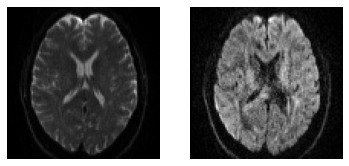

<Figure size 432x288 with 0 Axes>

In [7]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

In [8]:
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

In [21]:
print(gtab.info)

B-values shape (140,)
         min 0.000000
         max 2000.000000
B-vectors shape (140, 3)
          min -0.999775
          max 0.997102

None


In [22]:
print(gtab.bvals)

[   0. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]


In [26]:
S0s = data[:, :, :, gtab.b0s_mask]
print(S0s.shape)

(100, 100, 66, 12)


In [9]:
label_fname = get_fnames('stanford_labels')

In [10]:
labels = load_nifti_data(label_fname)
white_matter = (labels == 1) | (labels == 2)

In [11]:
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45)

In [42]:
from dipy.viz import window, actor, has_fury

if has_fury:
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
                                csa_peaks.peak_values,
                                colors=None))

    window.record(scene, out_path='csa_direction_field.png', size=(900, 900))

    if interactive:
        window.show(scene, size=(800, 800))

In [12]:
stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

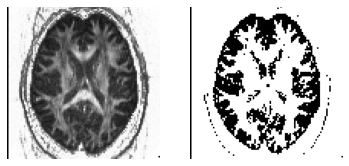

In [13]:
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

In [14]:
from dipy.tracking import utils

seed_mask = (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

In [15]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

In [ ]:
from dipy.viz import colormap, window, actor, has_fury

if has_fury:
    # Prepare the display objects.
    color = colormap.line_colors(streamlines)

    streamlines_actor = actor.line(streamlines,
                                   colormap.line_colors(streamlines))

    # Create the 3D display.
    scene = window.Scene()
    scene.add(streamlines_actor)

    # Save still images for this static example. Or for interactivity use
    window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
    if interactive:
        window.show(scene)

In [1]:
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response_ssst)
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.viz import window, actor, colormap, has_fury


In [2]:
interactive = False

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

seed_mask = (labels == 2)
white_matter = (labels == 1) | (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=1)

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order=6)
csd_fit = csd_model.fit(data, mask=white_matter)

  0%|          | 0/5578 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

100%|██████████| 58788/58788 [00:06<00:00, 8842.13it/s]


In [1]:
from dipy.data import read_stanford_labels, read_stanford_pve_maps

In [2]:
dwi_img, gtab, labels = read_stanford_labels()

In [3]:
img_pve_csf, img_pve_gm, img_pve_wm = read_stanford_pve_maps()

  0%|          | 0/7 [00:00<?, ? MB/s]

  0%|          | 0/12 [00:00<?, ? MB/s]

  0%|          | 0/8 [00:00<?, ? MB/s]

In [6]:
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
stopping_criterion = BinaryStoppingCriterion(img_pve_wm.get_fdata() > 0)

In [7]:
print(stopping_criterion)